In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [119]:
path = "./data/한파/S-DoT_NATURE_2022*.csv"

files = glob.glob(path)

df_list = [pd.read_csv(f, encoding='euc-kr') for f in files]

cold_df = pd.concat(df_list, ignore_index=True)

# 서울시 데이터만 필터링
cold_df = cold_df[cold_df['기관 명'] == '서울시']

# 컬럼명 공백 제거
cold_df.columns = cold_df.columns.str.strip()

# 필요한 컬럼만 추출
use_cols = ['기관 명', '등록일자', '기온(℃)']

cold_df = cold_df[use_cols]

# 컬럼명 영어로 변경
cold_df.columns = ['agency', 'datetime', 'temp']

cold_df

,agency,datetime,temp
0,서울시,2022-01-03 0:07,-3.0
1,서울시,2022-01-03 0:07,-2.4
2,서울시,2022-01-03 0:07,21.6
3,서울시,2022-01-03 0:07,-1.2
4,서울시,2022-01-03 0:07,-4.0
...,...,...,...
4580058,서울시,2022-12-28 23:07,-2.4
4580059,서울시,2022-12-28 23:07,NaN
4580060,서울시,2022-12-28 23:07,-2.5
4580061,서울시,2022-12-28 23:07,-2.1


In [120]:
# datetime 이상치 제거
# 문자열로
datetime_str = cold_df['datetime'].astype(str).str.strip()

# 소수점 제거
datetime_str = datetime_str.str.replace(r'\.0$', '', regex=True)

# 12~14자리 숫자(YYYYMMDDHHMMSS / YYYYMMDDHHMM)만 추출해서 파싱
dt_num = pd.to_datetime(datetime_str, format='%Y%m%d%H%M%S', errors='coerce')
dt_mix = pd.to_datetime(datetime_str, format='mixed', errors='coerce')

# 포맷 병합
cold_df['datetime'] = dt_num.fillna(dt_mix)

# NaT 제거
cold_df = cold_df.dropna(subset=['datetime'])

# 6) 일 단위 컬럼
cold_df['date'] = cold_df['datetime'].dt.date

# 서울의 공식 관측 사상 최저기온은 1927년 12월 31일의 -23.1℃
# 이상치 제거 (기온 -30도 이하)
cold_df = cold_df[cold_df['temp'] > -23.1]
cold_df = cold_df[cold_df['temp'] < 10]

C:\Users\Playdata\AppData\Local\Temp\ipykernel_23052\1710082435.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cold_df['date'] = cold_df['datetime'].dt.date


In [121]:
daily_min = cold_df.groupby('date')['temp'].min().reset_index()
daily_min.columns = ['date', 'temp']

# 한파 기준 -12도 이하인 날
cold_days = daily_min[daily_min['temp'] <= -12]
cold_days

,date,temp
0,2022-01-03,-22.2
1,2022-01-04,-19.7
2,2022-01-05,-22.8
3,2022-01-06,-20.0
4,2022-01-07,-21.6
...,...,...
148,2022-12-24,-22.5
149,2022-12-25,-22.8
150,2022-12-26,-22.8
151,2022-12-27,-21.7


In [122]:
# 미세먼지 데이터
dust_df = pd.read_csv("./data/미세먼지/서울시 대기질 자료 제공_2022.csv", encoding="euc-kr")
dust_df.columns = dust_df.columns.str.strip()

 # 구 단위로 되어 있는거 빼고 평균만 필터링
dust_df = dust_df[dust_df['구분'] == '평균']

dust_df['일시'] = pd.to_datetime(dust_df['일시'])
dust_df['date'] = dust_df['일시'].dt.date
dust_df = (
    dust_df.groupby('date')[['미세먼지(PM10)', '초미세먼지(PM2.5)']].mean().reset_index()
)
dust_df.columns = ['date', 'pm10', 'pm25']
dust_df

,date,pm10,pm25
0,2022-01-01,27.250000,14.708333
1,2022-01-02,34.750000,23.333333
2,2022-01-03,25.291667,14.791667
3,2022-01-04,33.833333,19.541667
4,2022-01-05,47.833333,29.375000
...,...,...,...
360,2022-12-27,49.208333,36.541667
361,2022-12-28,34.500000,21.250000
362,2022-12-29,30.291667,18.375000
363,2022-12-30,38.416667,27.625000


In [123]:
cold_df['date'] = pd.to_datetime(cold_df['date'])
cold_df = cold_df.drop(columns=['datetime'])
dust_df['date'] = pd.to_datetime(dust_df['date'])

# 한파 미세먼지 데이터 병합
cold_dust = pd.merge(cold_df, dust_df, on='date', how='inner')
cold_dust

,agency,temp,date,pm10,pm25
0,서울시,-3.0,2022-01-03,25.291667,14.791667
1,서울시,-2.4,2022-01-03,25.291667,14.791667
2,서울시,-1.2,2022-01-03,25.291667,14.791667
3,서울시,-4.0,2022-01-03,25.291667,14.791667
4,서울시,-2.8,2022-01-03,25.291667,14.791667
...,...,...,...,...,...
2189521,서울시,-2.0,2022-12-28,34.500000,21.250000
2189522,서울시,-2.4,2022-12-28,34.500000,21.250000
2189523,서울시,-2.5,2022-12-28,34.500000,21.250000
2189524,서울시,-2.1,2022-12-28,34.500000,21.250000


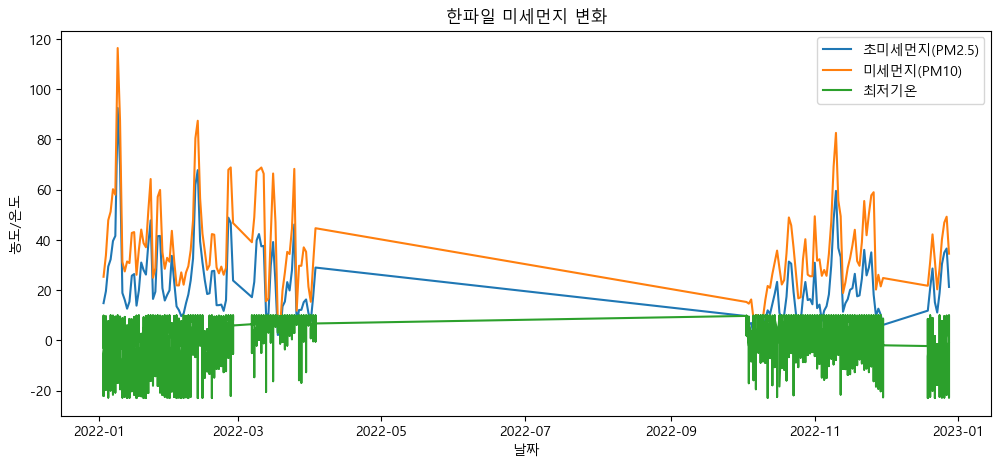

In [124]:
cold_dust = cold_dust.sort_values('date')

plot_df = cold_dust.dropna(subset=['pm25', 'pm10', 'temp'])
plt.figure(figsize=(12,5))
plt.plot(plot_df['date'], plot_df['pm25'], label='초미세먼지(PM2.5)')
plt.plot(plot_df['date'], plot_df['pm10'], label='미세먼지(PM10)')
plt.plot(plot_df['date'], plot_df['temp'], label='최저기온')
plt.title('한파일 미세먼지 변화')
plt.xlabel('날짜')
plt.ylabel('농도/온도')
plt.legend()
plt.show()

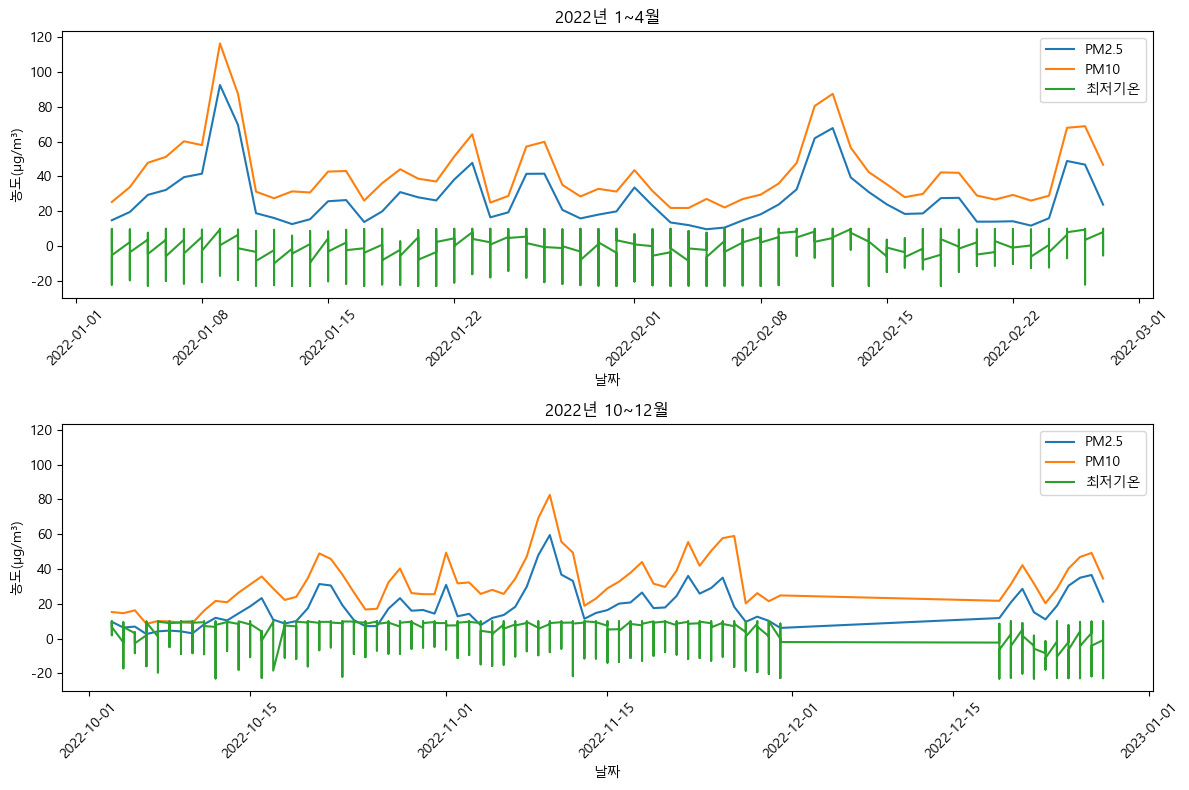

In [129]:
df_1to4 = cold_dust[(cold_dust['date'] >= '2022-01-01') & (cold_dust['date'] <= '2022-03-01')]
df_10to12 = cold_dust[(cold_dust['date'] >= '2022-10-01') & (cold_dust['date'] <= '2022-12-31')]

fig, axes = plt.subplots(2, 1, figsize=(12,8), sharey=True)

axes[0].plot(df_1to4['date'], df_1to4['pm25'], label='PM2.5')
axes[0].plot(df_1to4['date'], df_1to4['pm10'], label='PM10')
axes[0].plot(df_1to4['date'], df_1to4['temp'], label='최저기온')
axes[0].set_title('2022년 1~4월')
axes[0].legend()

axes[1].plot(df_10to12['date'], df_10to12['pm25'], label='PM2.5')
axes[1].plot(df_10to12['date'], df_10to12['pm10'], label='PM10')
axes[1].plot(df_10to12['date'], df_10to12['temp'], label='최저기온')
axes[1].set_title('2022년 10~12월')
axes[1].legend()

for ax in axes:
    ax.set_xlabel('날짜')
    ax.set_ylabel('농도(μg/m³)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
